In [1]:
%matplotlib inline

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<a href="https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/load_hpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading HPO results

In [2]:

import os
import math
from typing import Union

import numpy as np

from skopt.plots import plot_objective

from SeqMetrics import RegressionMetrics

from ai4water import Model
from ai4water.models import MLP
from ai4water.utils import TrainTestSplit
from ai4water.preprocessing import DataSet
from ai4water.datasets import mg_photodegradation
from ai4water.utils.utils import get_version_info
from ai4water.utils.utils import jsonize
from ai4water.hyperopt import HyperOpt, Categorical, Real, Integer

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
def objective_fn(
        prefix: str = None,
        return_model: bool = False,
        fit_on_all_training_data:bool = False,
        epochs:int = 100,
        verbosity: int = 0,
        **suggestions
)->Union[float, Model]:
    """
    This function must build, train and evaluate the ML model.
    The output of this function will be minimized by optimization algorithm.

    In this example we are considering same number of units and same activation for each
    layer. If we want to have (optimize) different number of units for each layer,
    willhave to modify the parameter space accordingly. The LSTM function
    can be used to have separate number of units and activation function for each layer.

    Parameters
    ----------
    prefix : str
        prefix to save the results. This argument will only be used after
        the optimization is complete
    return_model : bool, optional (default=False)
        if True, then objective function will return the built model. This
        argument will only be used after the optimization is complete
    epochs : int, optional
        the number of epochs for which to train the model
    verbosity : int, optional (default=1)
        determines the amount of information to be printed
    fit_on_all_training_data : bool, optional
        Whether to predict on all the training data (training+validation)
        or to training on only training data and evaluate on validation data.
        During hpo iterations, we will train the model on training data
        and evaluate on validation data. After hpo, we the model is
        trained on allt he training data and evaluated on test data.
    suggestions : dict
        a dictionary with values of hyperparameters at the iteration when
        this objective function is called. The objective function will be
        called as many times as the number of iterations in optimization
        algorithm.

    Returns
    -------
    float or Model
    """
    suggestions = jsonize(suggestions)
    global ITER

    # i) build model
    _model = Model(
        model=MLP(units=suggestions['units'],
                   num_layers=suggestions['num_layers'],
                   activation=suggestions['activation'],
                   dropout=0.2),
        batch_size=suggestions["batch_size"],
        lr=suggestions["lr"],
        prefix=prefix or PREFIX,
        epochs=epochs,
        input_features=data.columns.tolist()[0:-1],
        output_features=data.columns.tolist()[-1:],
        verbosity=verbosity)

    SUGGESTIONS[ITER] = suggestions

    # ii) train model
    
    if fit_on_all_training_data:
        _model.fit(x=TrainX, y=TrainY, validation_data=(TestX, TestY), verbose=0)
        prediction = _model.predict(x=TestX)
        true = TestY
    else:
        _model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), verbose=0)
        prediction = _model.predict(x=val_x)
        true = val_y

    # iii) evaluate model
    metrics = RegressionMetrics(true, prediction)
    val_score = metrics.rmse()


    # here we are evaluating model with respect to mse, therefore
    # we don't need to subtract it from 1.0
    if not math.isfinite(val_score):
        val_score = 9999

    print(f"{ITER} {round(val_score, 2)}")


    ITER += 1

    if return_model:
        return _model

    return val_score

In [4]:
param_space = [
    Integer(10, 30, name="units"),
    Integer(1, 2, name="num_layers"),
    Categorical(["relu", "elu", "tanh"], name="activation"),
    Real(0.00001, 0.01, name="lr"),
    Categorical([4, 8, 12, 16, 24], name="batch_size")
]

In [5]:
x0 = [14, 1, "relu", 0.001, 8]

In [12]:
num_iterations = 100 

In [13]:
optimizer = HyperOpt(
    algorithm="bayes",
    objective_fn=objective_fn,
    param_space=param_space,
    x0=x0,
    num_iterations=num_iterations, 
)


In [14]:
path = os.path.join(os.getcwd(), "results", "nn_bayes_results", "hpo_results.bin")
optimizer.load_results(path)

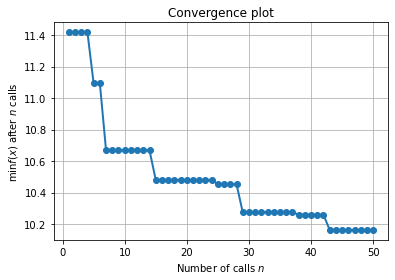

In [15]:
_ = optimizer._plot_convergence()

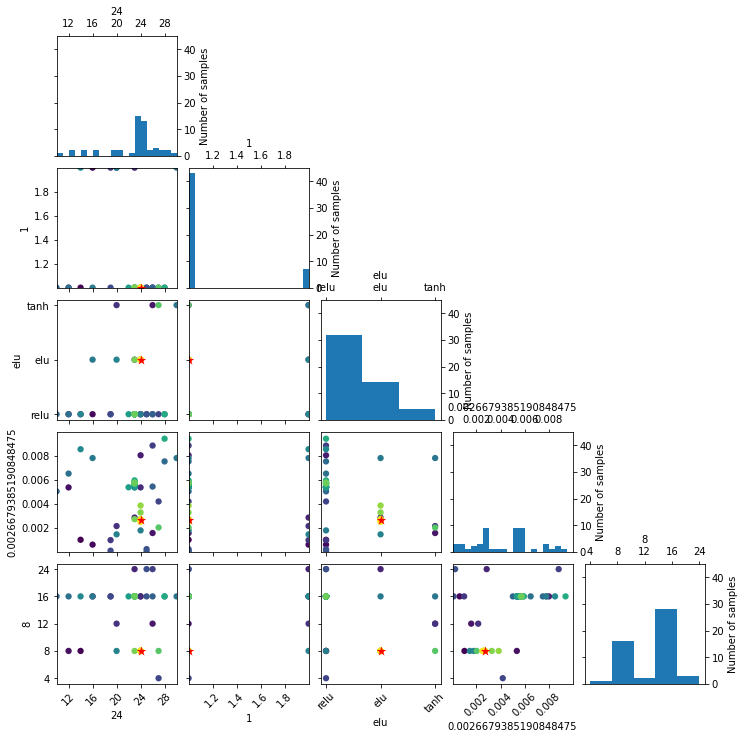

In [16]:
_ = optimizer._plot_evaluations()

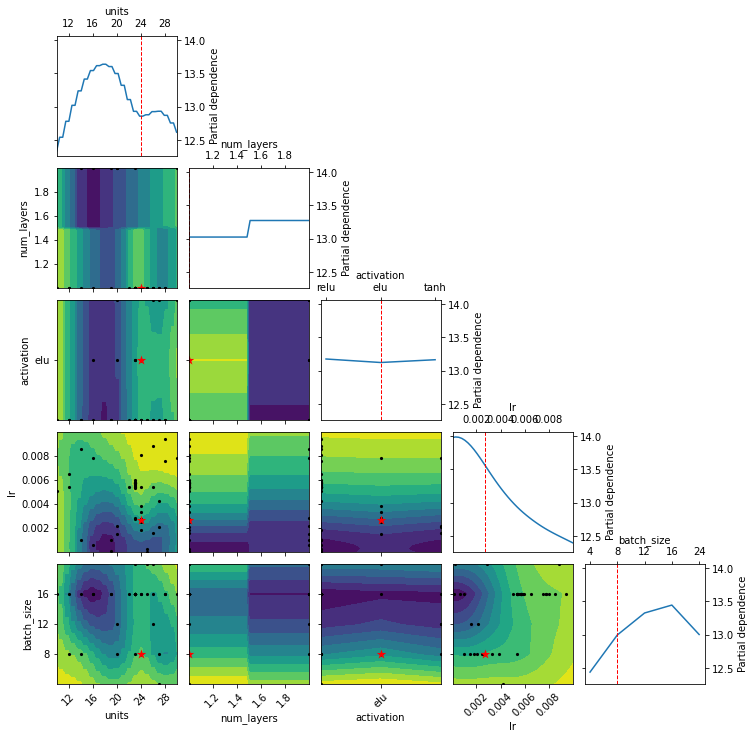

In [17]:
_ = plot_objective(optimizer.gpmin_results)

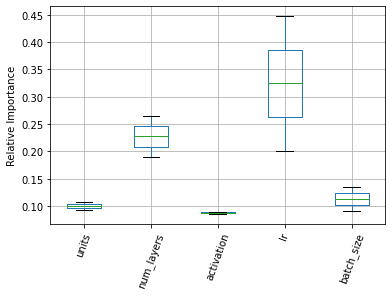

In [18]:
_ = optimizer.plot_importance()

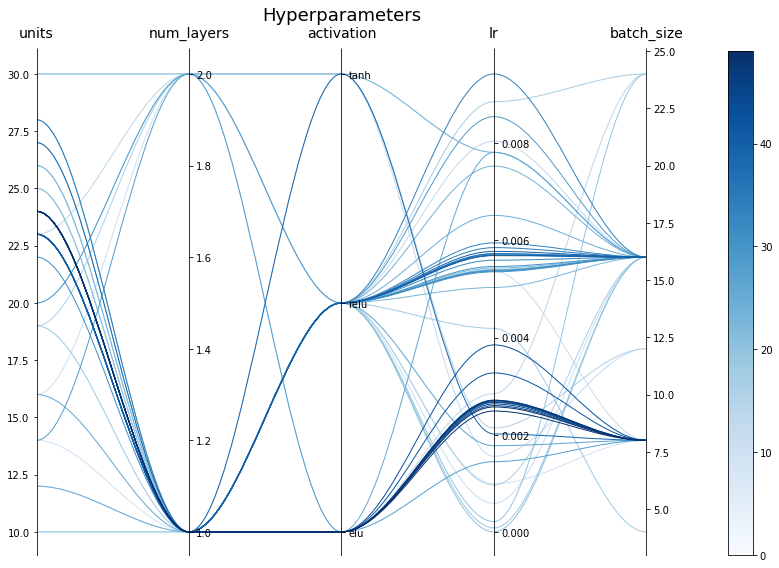

In [19]:
_ = optimizer.plot_parallel_coords(figsize=(12, 8))